1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

3. [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
data, target, coef = make_regression(n_samples=15000, n_features=2,
                                    n_informative=2, n_targets=1,
                                    noise=5, coef=True, random_state=12)

In [343]:
class LinearRegressor():
    
    def __init__(self, **kwargs):
        self.w = kwargs.get('w', np.zeros(2))
        self.eta = kwargs.get('eta', 0.1)
        self.max_iter = int(kwargs.get('max_iter', 1e6))
        self.min_weight_dist = kwargs.get('min_weight_dist', 1e-8)
        self.random_state = kwargs.get('random_state', -1)
        self.lamb = kwargs.get('l_2', 0)
        self.type_gd = kwargs.get('type_gd', 'gd')
        self.size_batch = kwargs.get('size_batch', 0)
        if self.type_gd == 'sgd':
            self.size_batch = 1
        if self.size_batch > 1:
            self.type_gd = 'mini_batch'
        elif self.size_batch == 1:
            self.type_gd = 'sgd'
        self.weight_dist = np.inf
        
    def calc_mse(self, w):
        err = np.mean((self.target_batch - self.target_pred_batch)**2)
        return err
    
    def fit(self, X, target):
        list_iter, list_err, w_list = [], [], []
        self.target = target
        w = self.w
        n = X.shape[0]
        if self.random_state != -1:
            np.random.seed(self.random_state)
        for i in range(self.max_iter):
            if self.type_gd != 'gd':
                train_ind = np.random.randint(X.shape[0], size=self.size_batch)
                self.target_pred_batch = np.dot(X[train_ind], w)
                self.target_batch = self.target[train_ind]
                X_batch = X[train_ind]
            elif self.type_gd == 'gd':
                self.target_pred_batch = np.dot(X, w)
                self.target_batch = self.target
                X_batch = X
            old_w = w.copy()
            w -= (self.eta * (1/n * 2 * np.dot(
                X_batch.T, (self.target_pred_batch - self.target_batch)) + 
                              + self.lamb * np.linalg.norm(w, ord=2)))
            err = self.calc_mse(w)
            norm = np.linalg.norm(w - old_w, ord=2)
            if i == 0:
                print(i, w, err, norm)
            if i % 10 == 0:
#                 print(i, w, err, norm)
                list_iter.append(i)
                list_err.append(err)
                w_list.append(w.copy())
            if np.linalg.norm(w - old_w, 2) < self.min_weight_dist:
                print(i, w, err, coef)
                list_iter.append(i)
                list_err.append(err)
                w_list.append(w.copy())
                break
        w_list = np.array(w_list)
        return list_iter, list_err, self.eta, w_list


In [370]:
def plot(x_1, y_1, x_2, y_2, eta, w_list_1, w_list_2):
    plt.figure(figsize=(10, 7))
    plt.plot(x_2, y_2, 'ro')
    plt.plot(x_1, y_1, 'bo')
#     plt.yscale('log')
#     plt.xscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
#     plt.legend()
    plt.title(f'Скорость обучения: {eta}')
    
    plt.figure(figsize=(10, 7))
    plt.title('Stochastic gradient descent')
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')

    
    plt.scatter(w_list_2[:, 0], w_list_2[:, 1], c='r')
    plt.scatter(w_list_1[:, 0], w_list_1[:, 1])
    plt.scatter(coef[0], coef[1], c='y')
    # plt.plot(w_list[:, 0], w_list[:, 1])


    plt.show()

In [373]:
lr = LinearRegressor(max_iter=1e4, eta=0.2, random_state=12)

In [374]:
%%time
list_iter, list_err, eta, w_list = lr.fit(data, target)

0 [4.88321589 0.90183111] 181.88599375187582 4.965792660594817
41 [12.4264213   2.38700599] 24.80205813298141 [12.43432489  2.32201338]
CPU times: user 86.2 ms, sys: 67 µs, total: 86.2 ms
Wall time: 21.6 ms


In [382]:
lr_sgd = LinearRegressor(max_iter=1e5, eta=0.2, type_gd='sgd', random_state=12)

In [383]:
%%time
list_iter_sgd, list_err_sgd, eta_sgd, w_list_sgd = lr_sgd.fit(data, target)

0 [ 0.00034094 -0.00012606] 210.35315481955374 0.0003634973980010819
60476 [9.87705442 1.87621374] 1.0901456103353234e-09 [12.43432489  2.32201338]
CPU times: user 4.31 s, sys: 0 ns, total: 4.31 s
Wall time: 4.3 s


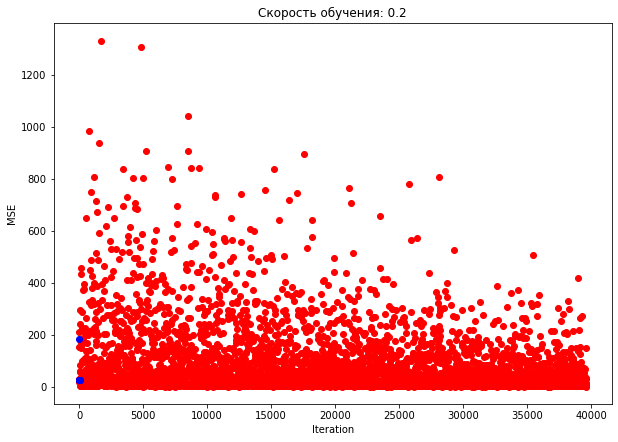

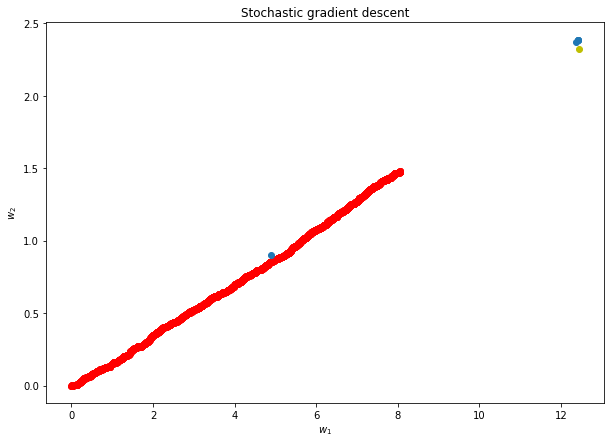

In [371]:
plot(list_iter, list_err, list_iter_sgd, list_err_sgd,
     eta, w_list, w_list_sgd)

В данном случае при равной скорости обучения стохастический градиентный спуск проигрывает обычному - он работает дольше, а коэфициенты далеки от истинных, как вариант можно отключить автозавершение обучения по критерию очень малого значения евклидовой нормы разницы векторов весов, либо уменьшить ее еще больше. При уменьшении скорости обучения стохастический градиентный спуск любит сваливаться в локальный минимум и результаты становятся еще хуже. Конкретно для этой задачи самое эффективное - использовать обычный градиентный спуск со скоростью обучения 0.2(самый быстрый вариант).

In [366]:
lr_l_2 = LinearRegressor(max_iter=1e5, eta=0.2, l_2=1e-8, random_state=12)
lr_l_2_sgd = LinearRegressor(max_iter=1e5, eta=0.2, l_2=1e-8, type_gd='sgd', random_state=12)


In [367]:
%%time
list_iter, list_err, eta, w_list = lr_l_2.fit(data, target)

0 [4.88321589 0.90183111] 181.88599375187582 4.965792660594817
41 [12.42642124  2.38700593] 24.802058132981422 [12.43432489  2.32201338]
CPU times: user 109 ms, sys: 3.93 ms, total: 113 ms
Wall time: 27.4 ms


In [368]:
%%time
list_iter_sgd, list_err_sgd, eta_sgd, w_list_sgd = lr_l_2_sgd.fit(data, target)

0 [ 0.00034094 -0.00012606] 210.35315481955374 0.0003634973980010819
39623 [8.0632991  1.47865477] 1.46582987568623e-06 [12.43432489  2.32201338]
CPU times: user 2.9 s, sys: 3.89 ms, total: 2.9 s
Wall time: 2.9 s


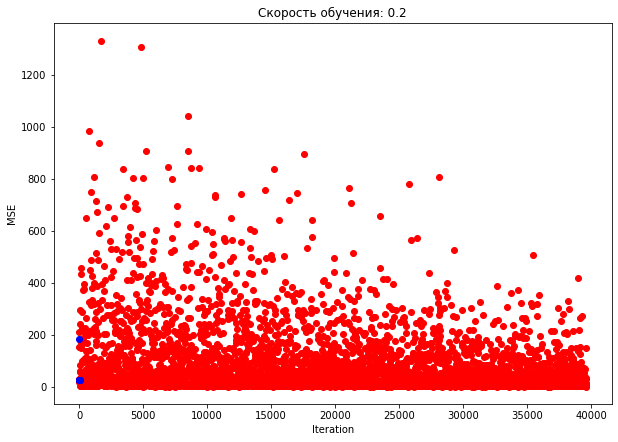

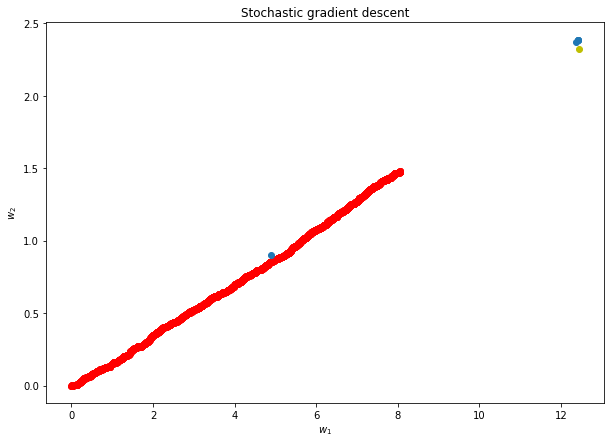

In [372]:
plot(list_iter, list_err, list_iter_sgd, list_err_sgd,
     eta, w_list, w_list_sgd)

Особо большой разницы не наблюдается, за исключением сокращения числа итераций у стохастического градиентного спуска, в остальном все почти идентично(можно было бы увеличить значение лямбды, но тогда получаем переполнение и стохастический градиентный спуск не отрабатывает как должен)